In [2]:
# Veri İşleme ve Analiz Kütüphaneleri
import pandas as pd  # DataFrame ile tablo verilerini okuma, işleme, kaydetme
import numpy as np  # Sayısal hesaplamalar ve array işlemleri
import os  # Dosya yolları oluşturma, klasör kontrolü
import re  # Regex ile metin temizleme (özel karakter kaldırma)
import nltk  # Natural Language Toolkit - metin işleme araçları
from nltk.corpus import stopwords  # "the", "is" gibi gereksiz kelimeleri filtreleme
from nltk.stem import WordNetLemmatizer  # Kelimeleri kök formuna indirgeme (running → run)
import time  # İşlem süresi ölçümü (opsiyonel)
import json  # JSONL dosyalarını okuma ve parse etme

# Görselleştirme Kütüphaneleri
import matplotlib.pyplot as plt  # Grafik çizimi (figure, subplot, savefig)
import seaborn as sns  # Estetik istatistiksel grafikler (countplot, histplot, kdeplot)
from wordcloud import WordCloud  # Kelime bulutları oluşturma (sık geçen kelimeleri görselleştirme)

In [4]:
try:
    stop_words = set(stopwords.words("english"))# "the" "a" "is" "in" "stopwords"
except LookupError:
    nltk.download("stopwords", quiet=True) 
    nltk.download("wordnet", quiet=True) 
    nltk.download('omw-1.4', quiet=True)
    stop_words = set(stopwords.words("english"))

In [7]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def flatten_jsonl_data(file_path):
    all_messages = []
    print(f"Processing file: {file_path}")
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # satırın başındaki/sonundaki boşlukları temizle
            line = line.strip()
            
            # eğer satır boşsa (dosya sonundaki boş satır gibi), bu satırı atla
            if not line:
                continue
            
            # satırı bir JSON objesi olarak yükle
            row = json.loads(line)
            
            for i in range(len(row["messages"])):
                message_data = {
                    'game_id': row['game_id'],
                    'speaker': row['speakers'][i],
                    'receiver': row['receivers'][i],
                    'message_text': row['messages'][i],
                    'sender_intention': row['sender_labels'][i],
                    'game_score': row['game_score'][i],
                    'game_score_delta': row['game_score_delta'][i],
                    'year': row['years'][i],
                    'season': row['seasons'][i],
                    'original_fold': row.get('acl2020_fold', os.path.basename(file_path).split('.')[0])
                }
                all_messages.append(message_data)
                
    return pd.DataFrame(all_messages)

def process_dataframe(df):
    df_processed = df.copy()
    
    df_processed['target'] = df_processed['sender_intention'].apply(lambda x: 1 if x == False else 0)
    df_processed['cleaned_text'] = df_processed['message_text'].apply(clean_text)
    
    numeric_cols = ['game_score', 'game_score_delta', 'year']
    for col in numeric_cols:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    df_processed = df_processed.fillna(0)
    
    df_processed['message_length'] = df_processed['message_text'].apply(len)
    
    return df_processed

In [16]:
base_project_path = os.path.dirname(os.getcwd())
data_folder_path = os.path.join(base_project_path, "data", "raw", "2020_acl_diplomacy", "data")
train_path = os.path.join(data_folder_path, "train.jsonl")
val_path = os.path.join(data_folder_path, "validation.jsonl")
test_path = os.path.join(data_folder_path, "test.jsonl")
print(base_project_path)
print(data_folder_path)

c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks
c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\raw\2020_acl_diplomacy\data


In [18]:
OUTPUT_DIR = os.path.join(base_project_path, "data", "processed", "diplomacy")
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE_PATH = os.path.join(OUTPUT_DIR, "diplomacy_processed.parquet")
TRAIN_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "train_processed.parquet")
VAL_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "val_processed.parquet")
TEST_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "test_processed.parquet")

In [17]:
print(train_path, os.path.exists(train_path))

c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\raw\2020_acl_diplomacy\data\train.jsonl True


In [20]:
if os.path.exists(OUTPUT_FILE_PATH):
    # eğer dosya varsa, ağır işi atla ve dosyayı doğrudan yükle
    df_eda = pd.read_parquet(OUTPUT_FILE_PATH)
    
else:
    # eğer dosya yoksa
    df_train = flatten_jsonl_data(train_path)
    df_val = flatten_jsonl_data(val_path)
    df_test = flatten_jsonl_data(test_path)

    df_eda = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print(f"Total length: {len(df_eda)}")
    
    # Ham df_eda'daki problematik sütunları düzelt (parquet uyumluluğu için)
    for col in ['game_score', 'game_score_delta', 'year']:
        if col in df_eda.columns:
            # Liste/array ise ilk elemanı al, değilse olduğu gibi bırak
            df_eda[col] = df_eda[col].apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else x)
            # Sayıya çevir
            df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce').fillna(0)
    
    df_train = process_dataframe(df_train)
    df_val = process_dataframe(df_val)
    df_test = process_dataframe(df_test)

    df_train.to_parquet(TRAIN_OUTPUT_PATH, index=False)
    df_val.to_parquet(VAL_OUTPUT_PATH, index=False)
    df_test.to_parquet(TEST_OUTPUT_PATH, index=False)

    df_eda.to_parquet(OUTPUT_FILE_PATH, index=False)

print("\nCompleted. Info: ")
print(df_eda.info())
if 'df_train' in locals():
    print(df_train.info())
if 'df_val' in locals():
    print(df_val.info())
if 'df_test' in locals():
    print(df_test.info())

Processing file: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\raw\2020_acl_diplomacy\data\train.jsonl
Processing file: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\raw\2020_acl_diplomacy\data\validation.jsonl
Processing file: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\raw\2020_acl_diplomacy\data\test.jsonl
Total length: 17289

Completed. Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_id           17289 non-null  int64 
 1   speaker           17289 non-null  object
 2   receiver          17289 non-null  object
 3   message_text      17289 non-null  object
 4   sender_intention  17289 non-null  bool  
 5   game_score        17289 non-null  int64 
 6   game_score_delta  17289 non-null  int64 
 7   year              17289 non-null  int64

In [26]:
base_path = os.path.dirname(os.getcwd())
# train_processed.parquet kullanıyoruz çünkü process_dataframe() ile target, cleaned_text, message_length sütunları eklenmiş
data_path = os.path.join(base_path, "data", "processed", "diplomacy", "train_processed.parquet")
reports_dir = os.path.join(base_path, "reports", "figures")
os.makedirs(reports_dir, exist_ok=True)

In [27]:
try:
    data = pd.read_parquet(data_path)
    sns.set_theme(style="whitegrid")
    print(f"path" + data_path + " loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: '{data_path}' FILE NOT FOUND!")

pathc:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\train_processed.parquet loaded successfully.


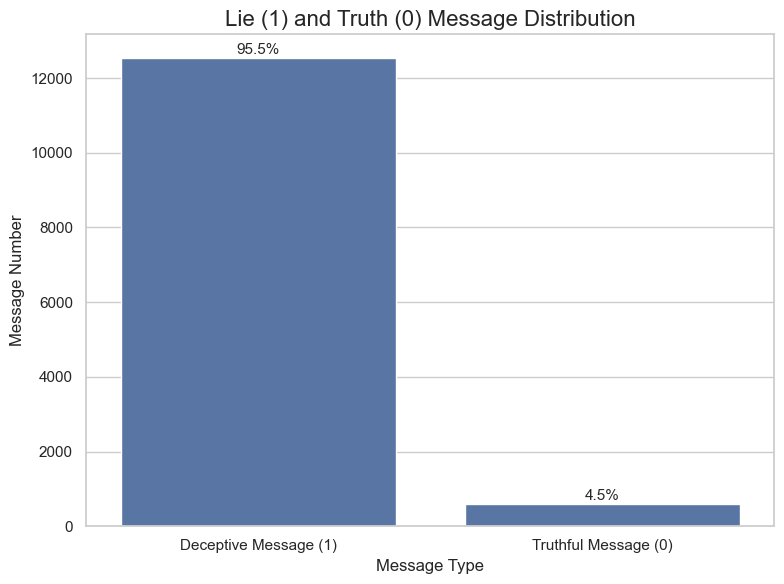

In [28]:
plt.figure(figsize=(8, 6))
ax1 = sns.countplot(x='target', data=data) 
plt.title('Lie (1) and Truth (0) Message Distribution', fontsize=16)
plt.xlabel('Message Type', fontsize=12)
plt.ylabel('Message Number', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Deceptive Message (1)', 'Truthful Message (0)'])

total = len(data)
for p in ax1.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 100
    ax1.annotate(percentage, (x, y), ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_01_class_distribution.png"))
plt.show()

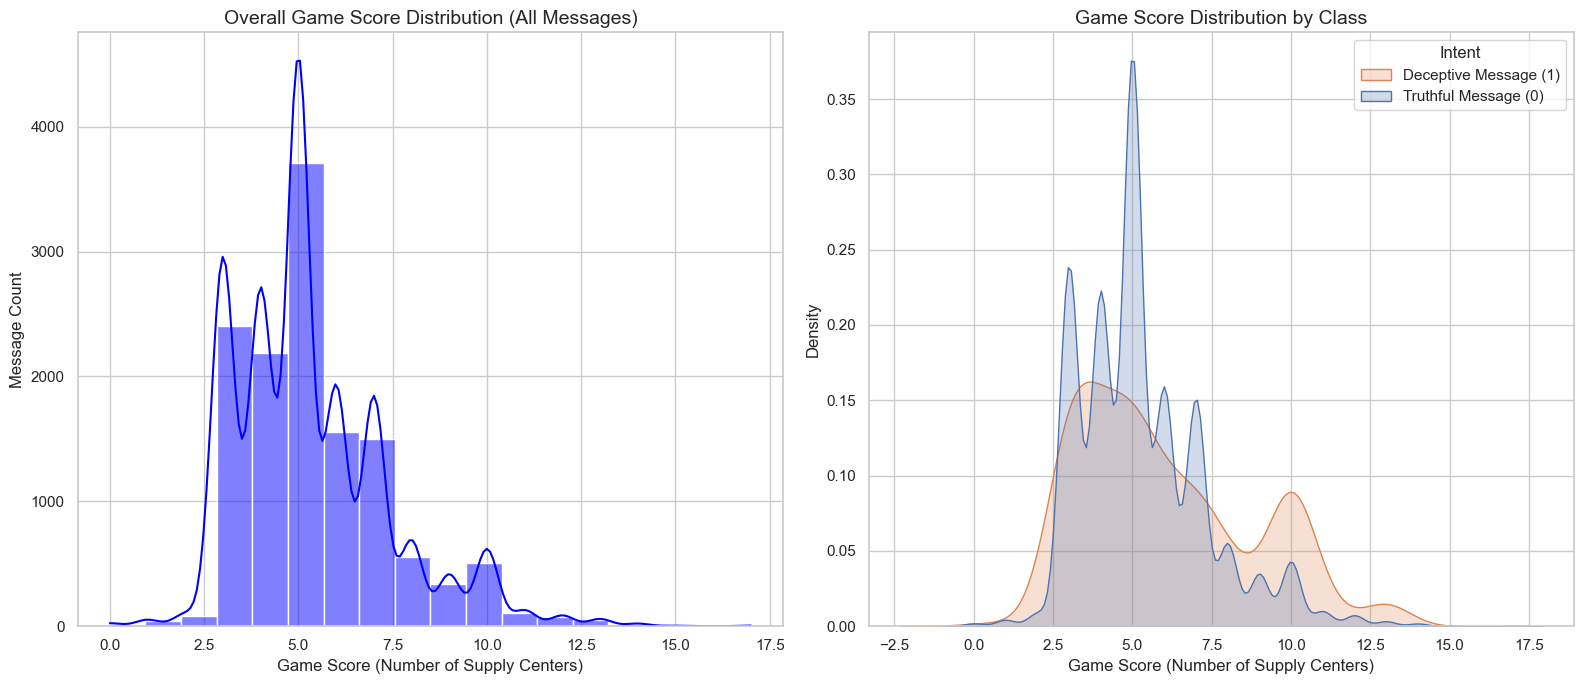

In [29]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)  
sns.histplot(data=data, x='game_score', bins=18, kde=True, color='blue')
plt.title('Overall Game Score Distribution (All Messages)', fontsize=14)
plt.xlabel('Game Score (Number of Supply Centers)', fontsize=12)
plt.ylabel('Message Count', fontsize=12)

plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='game_score', hue='target', 
            fill=True, common_norm=False) 
plt.title('Game Score Distribution by Class', fontsize=14)
plt.xlabel('Game Score (Number of Supply Centers)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Intent', labels=['Deceptive Message (1)', 'Truthful Message (0)'])

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_02_score_distribution.png"))
plt.show()

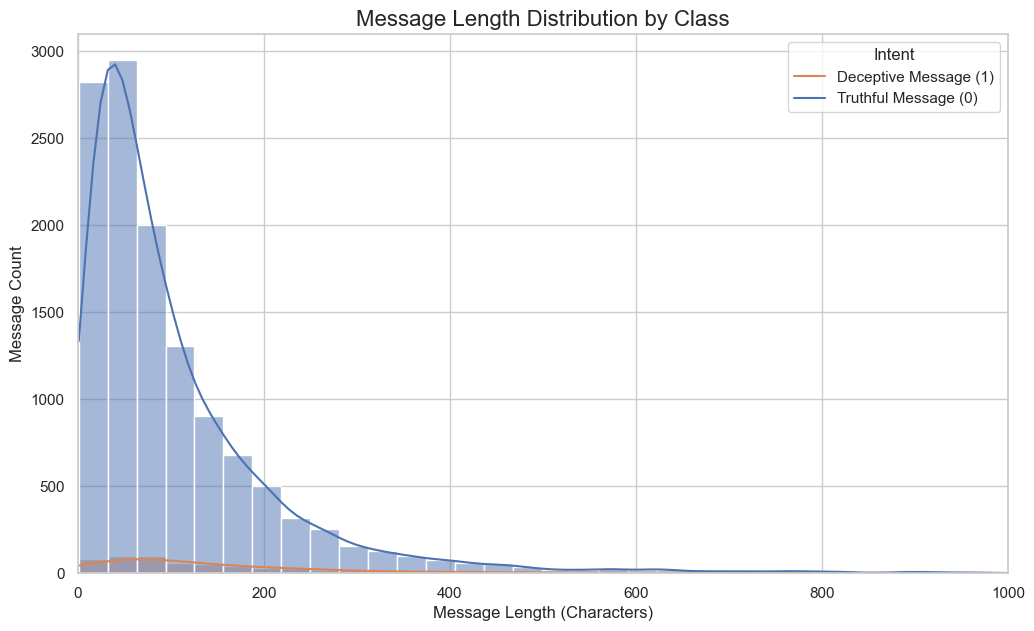

In [36]:
plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='message_length', hue='target', 
  bins=50, kde=True, common_norm=False)
plt.title('Message Length Distribution by Class', fontsize=16) 
plt.xlabel('Message Length (Characters)', fontsize=12) 
plt.ylabel('Message Count', fontsize=12) 

plt.xlim(0, 1000) 
plt.legend(title='Intent', labels=['Deceptive Message (1)', 'Truthful Message (0)']) 
plt.savefig(os.path.join(reports_dir, "diplomacy_03_length_distribution.png"))
plt.show()

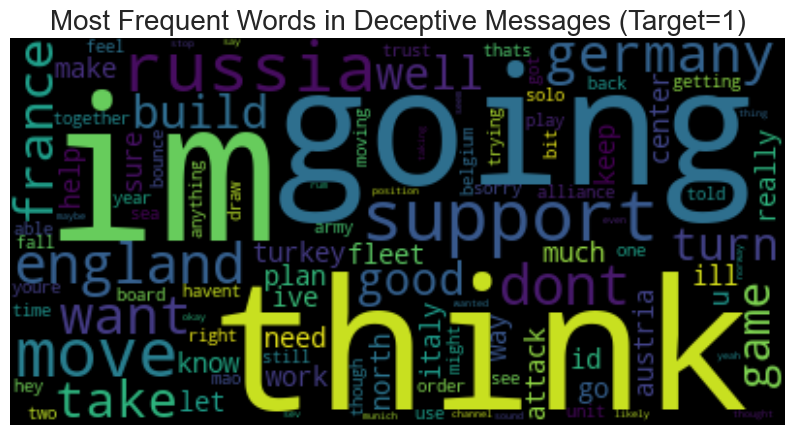

In [35]:
spam_text = " ".join(review for review in data[data['target'] == 1]['cleaned_text'] if review)

if spam_text:
    plt.figure(figsize=(10, 7))
    wordcloud_spam = WordCloud(max_words=100, background_color="black", collocations=False).generate(spam_text)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Frequent Words in Deceptive Messages (Target=1)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_lie.png"))
    plt.show()
else:
    print("No text found to generate word cloud for deceptive messages.")

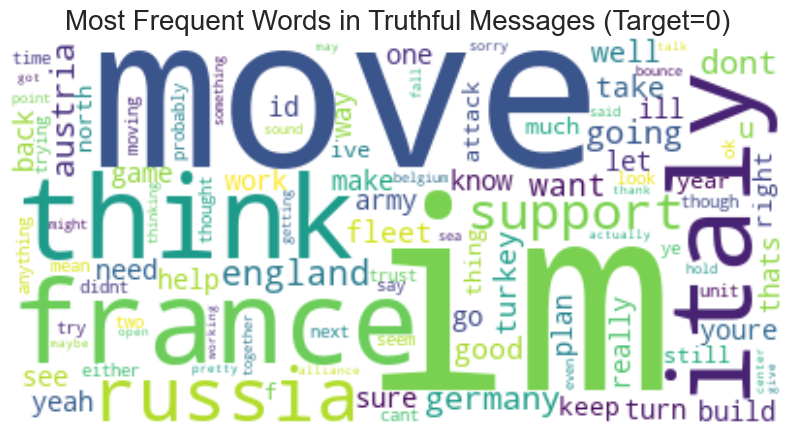

In [39]:
real_text = " ".join(review for review in data[data['target'] == 0]['cleaned_text'] if review)
if real_text:
    plt.figure(figsize=(10, 7))
    wordcloud_real = WordCloud(max_words=100, background_color="white", collocations=False).generate(real_text)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Frequent Words in Truthful Messages (Target=0)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_truth.png"))
    plt.show()
else:
    print("No text found to generate word cloud for truthful messages.")

In [5]:
import pandas as pd
import os
import json
import re

In [6]:
base_path = os.path.dirname(os.getcwd())
moves_dir = os.path.join(base_path, "data", "raw", "2020_acl_diplomacy", "moves")

processed_dir = os.path.join(base_path, "data", "processed", "diplomacy")
os.makedirs(processed_dir, exist_ok=True)
MOVES_OUTPUT_PATH = os.path.join(processed_dir, "diplomacy_all_moves.parquet")

if os.path.exists(MOVES_OUTPUT_PATH):
    print(f"'{MOVES_OUTPUT_PATH}' file already exists")
    moves_df = pd.read_parquet(MOVES_OUTPUT_PATH)
else:
    all_moves_data = []

    file_pattern = re.compile(r"DiplomacyGame(\d+)_(\d+)_(\w+)\.json")

    for filename in os.listdir(moves_dir):
        if filename.endswith(".json"):
            match = file_pattern.match(filename)
            if not match:
                print(f"'{filename}' does not match any filename, skipping...")
                continue

            game_id = int(match.group(1))
            year = int(match.group(2))
            season = match.group(3).title()

            file_path = os.path.join(moves_dir, filename)
            
            with open(file_path, 'r', encoding='utf-8') as f:
                game_data = json.load(f)
                orders = game_data.get('orders', {})
                
                for country, country_orders in orders.items():
                    all_moves_data.append({
                        'game_id': game_id,
                        'year': year,
                        'season': season,
                        'country': country,
                        'orders_json': country_orders
                    })

    moves_df = pd.DataFrame(all_moves_data)
    
    moves_df.to_parquet(MOVES_OUTPUT_PATH, index=False)
    print(f"Saved at '{MOVES_OUTPUT_PATH}'")

'c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\diplomacy_all_moves.parquet' file already exists


In [7]:
MOVES_FILE = os.path.join(processed_dir, "diplomacy_all_moves.parquet")

WORDS_TRAIN_FILE = os.path.join(processed_dir, "train_processed.parquet")
WORDS_VAL_FILE = os.path.join(processed_dir, "val_processed.parquet")
WORDS_TEST_FILE = os.path.join(processed_dir, "test_processed.parquet")

ENRICHED_TRAIN_FILE = os.path.join(processed_dir, "train_enriched.parquet")
ENRICHED_VAL_FILE = os.path.join(processed_dir, "val_enriched.parquet")
ENRICHED_TEST_FILE = os.path.join(processed_dir, "test_enriched.parquet")

In [8]:
try:
    moves_df = pd.read_parquet(MOVES_FILE)
    train_df = pd.read_parquet(WORDS_TRAIN_FILE)
    val_df = pd.read_parquet(WORDS_VAL_FILE)
    test_df = pd.read_parquet(WORDS_TEST_FILE)
    print("Gerekli 'Sözler' (train/val/test) ve 'Eylemler' (moves) dosyaları yüklendi.")
except FileNotFoundError as e:
    print(f"HATA: Gerekli bir dosya bulunamadı! Lütfen önceki adımları tamamlayın.")
    print(f"Eksik dosya: {e.filename}")
    raise e

Gerekli 'Sözler' (train/val/test) ve 'Eylemler' (moves) dosyaları yüklendi.


In [9]:
PROMISE_SUPPORT_WORDS = ['support', 'help', 'ally', 'friend', 'defend', 'partner']
PROMISE_ATTACK_WORDS = ['attack', 'move', 'take', 'invade', 'stab', 'push']
PROMISE_HOLD_WORDS = ['hold', 'stay', 'defend', 'wait']

In [10]:
def parse_orders(orders_json):
    if not isinstance(orders_json, dict):
        return 0, 0, 0
    
    support_count = 0
    move_count = 0
    hold_count = 0
    
    for unit_order in orders_json.values():
        if not isinstance(unit_order, dict):
            continue
            
        order_type = unit_order.get('type')
        if order_type == 'SUPPORT':
            support_count += 1
        elif order_type == 'MOVE':
            move_count += 1
        elif order_type == 'HOLD':
            hold_count += 1
            
    return support_count, move_count, hold_count

def enrich_dataset(words_df, moves_df):
    merged_df = pd.merge(
        words_df,
        moves_df,
        how='left',
        left_on=['game_id', 'year', 'season', 'speaker'],
        right_on=['game_id', 'year', 'season', 'country']
    )
    
    new_features = merged_df['orders_json'].apply(
        lambda x: pd.Series(parse_orders(x), index=['action_support_count', 'action_move_count', 'action_hold_count'])
    )
    
    enriched_df = pd.concat([merged_df, new_features], axis=1)

    final_df = enriched_df.drop(columns=['country', 'orders_json'])
    
    return final_df

def create_mismatch_features(row):
    text = row['cleaned_text']
    
    # 1. Söz (Promise) Tespiti
    promise_support = 1 if any(word in text for word in PROMISE_SUPPORT_WORDS) else 0
    promise_attack = 1 if any(word in text for word in PROMISE_ATTACK_WORDS) else 0
    promise_hold = 1 if any(word in text for word in PROMISE_HOLD_WORDS) else 0
    
    # 2. Eylem (Action) Tespiti
    action_support = 1 if row['action_support_count'] > 0 else 0
    action_attack = 1 if row['action_move_count'] > 0 else 0
    action_hold = 1 if row['action_hold_count'] > 0 else 0
    
    # 3. Çelişki (Mismatch) Tespiti
    mismatch_support_vs_attack = 1 if (promise_support == 1 and action_attack == 1) else 0
    mismatch_attack_vs_no_attack = 1 if (promise_attack == 1 and action_attack == 0) else 0
    mismatch_support_vs_no_support = 1 if (promise_support == 1 and action_support == 0) else 0

    return pd.Series([
        promise_support, promise_attack, promise_hold,
        mismatch_support_vs_attack, mismatch_attack_vs_no_attack, mismatch_support_vs_no_support
    ], index=[
        'promise_support', 'promise_attack', 'promise_hold',
        'mismatch_support_vs_attack', 'mismatch_attack_vs_no_attack', 'mismatch_support_vs_no_support'
    ])

def create_final_dataset(words_df, moves_df):
    # Adım 3a: Birleştirme (enrich_dataset'in ilk kısmı)
    merged_df = pd.merge(
        words_df,
        moves_df,
        how='left', 
        left_on=['game_id', 'year', 'season', 'speaker'],
        right_on=['game_id', 'year', 'season', 'country']
    )
    
    # Adım 3b: Temel Eylem Sayılarını Oluştur (enrich_dataset'in ikinci kısmı)
    action_counts_df = merged_df['orders_json'].apply(
        lambda x: pd.Series(parse_orders(x), index=['action_support_count', 'action_move_count', 'action_hold_count'])
    )
    
    # Eylem sayılarını birleştir
    enriched_df = pd.concat([merged_df, action_counts_df], axis=1)
    
    # Adım 3c: Gelişmiş Çelişki Özelliklerini Oluştur (create_mismatch_features'ı uygula)
    print("Çelişki özellikleri (mismatch features) oluşturuluyor...")
    mismatch_features_df = enriched_df.apply(create_mismatch_features, axis=1)
    
    # Çelişki özelliklerini de birleştir
    final_df = pd.concat([enriched_df, mismatch_features_df], axis=1)
    
    # Adım 3d: Gereksiz sütunları temizle
    final_df = final_df.drop(columns=['country', 'orders_json'])
    
    return final_df


def process_and_save_final_data(input_path, output_path):
    """
    Veriyi yükler, yeni çelişki özelliklerini ekler ve son halini kaydeder.
    """
    if os.path.exists(output_path):
        print(f"✅ '{output_path}' zaten mevcut. Yükleniyor...")
        return pd.read_parquet(output_path)
    
    print(f"'{os.path.basename(input_path)}' yükleniyor ve işleniyor...")
    df = pd.read_parquet(input_path)
    
    # Yeni çelişki özelliklerini oluştur
    new_features_df = df.apply(create_mismatch_features, axis=1)
    
    # Yeni özellikleri ana DataFrame'e ekle
    df_final = pd.concat([df, new_features_df], axis=1)
    
    # Son halini kaydet
    df_final.to_parquet(output_path, index=False)
    print(f"✅ '{output_path}' başarıyla oluşturuldu ve kaydedildi.")
    return df_final

In [11]:
FINAL_TRAIN_FILE = os.path.join(processed_dir, "train_final.parquet")
FINAL_VAL_FILE = os.path.join(processed_dir, "val_final.parquet")
FINAL_TEST_FILE = os.path.join(processed_dir, "test_final.parquet")

In [12]:
if os.path.exists(FINAL_TRAIN_FILE) and os.path.exists(FINAL_VAL_FILE) and os.path.exists(FINAL_TEST_FILE):
    print("✅ Tüm NİHAİ (final) dosyalar zaten mevcut. İşlem atlanıyor.")
else:
    print("\n--- Eğitim Seti Zenginleştiriliyor ---")
    train_final_df = create_final_dataset(train_df, moves_df)
    train_final_df.to_parquet(FINAL_TRAIN_FILE, index=False)
    print(f"✅ Nihai eğitim seti kaydedildi: {FINAL_TRAIN_FILE}")

    print("\n--- Doğrulama Seti Zenginleştiriliyor ---")
    val_final_df = create_final_dataset(val_df, moves_df)
    val_final_df.to_parquet(FINAL_VAL_FILE, index=False)
    print(f"✅ Nihai doğrulama seti kaydedildi: {FINAL_VAL_FILE}")

    print("\n--- Test Seti Zenginleştiriliyor ---")
    test_final_df = create_final_dataset(test_df, moves_df)
    test_final_df.to_parquet(FINAL_TEST_FILE, index=False)
    print(f"✅ Nihai test seti kaydedildi: {FINAL_TEST_FILE}")


--- Eğitim Seti Zenginleştiriliyor ---
Çelişki özellikleri (mismatch features) oluşturuluyor...
Çelişki özellikleri (mismatch features) oluşturuluyor...
✅ Nihai eğitim seti kaydedildi: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\train_final.parquet

--- Doğrulama Seti Zenginleştiriliyor ---
Çelişki özellikleri (mismatch features) oluşturuluyor...
✅ Nihai eğitim seti kaydedildi: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\train_final.parquet

--- Doğrulama Seti Zenginleştiriliyor ---
Çelişki özellikleri (mismatch features) oluşturuluyor...
✅ Nihai doğrulama seti kaydedildi: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\val_final.parquet

--- Test Seti Zenginleştiriliyor ---
✅ Nihai doğrulama seti kaydedildi: c:\Users\aadil\Desktop\YAP470\amazon-fake-review-detector\notebooks\data\processed\diplomacy\val_final.parquet

--- Test Seti Zenginleşti